Code to generate Fig. 1 in Sauthoff and others, 202X, _Journal_.

Written 2023-07-06 by W. Sauthoff (sauthoff@mines.edu)

# Setup computing environment

This code requires a ~32 gb server instance.

In [1]:
# Install dependency not pre-installed in CryoCloud
%pip install openpyxl --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import earthaccess
import geopandas as gpd
from math import radians
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import pandas as pd
from pyproj import CRS, Transformer
import rioxarray
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

# Update the default font to Arial (and add backup if not found)
plt.rcParams['font.family'] = ['sans-serif']

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/Fig1_subglacial_lake_distribtion'
    OUTPUT_DIR_GIT = '/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output'

# Define utility function
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [3]:
def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True, prefix=None, suffix=None, suffix_pattern=None, file_extension=None):
    '''
    Filter the GeoDataFrame based on processed lake names from the folder contents.
    
    Args:
    gdf: GeoDataFrame to be filtered.
    folder_path: Path to the directory containing files and/or subdirectories.
    exclude: If True, excludes rows where the 'name' is in the folder_path directories or files.
             If False, includes only rows where the 'name' is in the folder_path directories or files.
    prefix: Optional string to remove from the beginning of filenames.
    suffix: Optional string to remove from the end of filenames.
    suffix_pattern: Optional regex pattern to remove from the end of filenames.
    file_extension: Optional string specifying the file extension to filter (e.g., 'png', 'txt').
    
    Returns:
    GeoDataFrame filtered based on the presence of 'name' in folder_path.

    # Example usage:
    remaining_lakes = filter_gdf_by_folder_contents(
        stationary_lakes_gdf, 
        folder_path,
        prefix='plot_evolving_outlines_time_series_', 
        suffix_pattern=r'\d+\.\d+m-level_\d+x-with',
        file_extension='txt'
    )
    '''
    def process_name(name):
        """Helper function to remove prefix and suffix from a name"""
        processed_name = name
        
        # First strip the file extension if it exists
        processed_name = os.path.splitext(processed_name)[0]
        
        if prefix and processed_name.startswith(prefix):
            processed_name = processed_name[len(prefix):]
            
        if suffix_pattern:
            processed_name = re.sub(suffix_pattern + '$', '', processed_name)
        elif suffix and processed_name.endswith(suffix):
            processed_name = processed_name[:-len(suffix)]
            
        return processed_name.lower().strip()
    
    # Get all files and filter by extension if specified
    all_files = os.listdir(folder_path)
    if file_extension:
        clean_extension = file_extension.lstrip('.')
        all_files = [f for f in all_files if f.lower().endswith(f'.{clean_extension.lower()}')]
    
    # Process filenames to get lake names
    names_in_folder = {
        process_name(name)
        for name in all_files
    }
    
    # Filter without adding and then dropping a new column
    gdf_filtered = gdf[gdf['name'].str.lower().str.strip().apply(
        lambda x: (x not in names_in_folder) if exclude else (x in names_in_folder)
    )]
    
    return gdf_filtered.reset_index(drop=True)

# Import datasets

In [4]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# # https://nsidc.org/data/nsidc-0593/versions/1
# shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_coastline_v02.0.shp' 
# moa_2009_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_groundingline_v02.0.shp' 
# moa_2009_groundingline = gpd.read_file(shp)

# # https://nsidc.org/data/nsidc-0730/versions/1
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
# moa_2014_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
# moa_2014_groundingline = gpd.read_file(shp)

In [5]:
# Find cloud-hosted MEaSUREs Phase-Based Antarctica Ice Velocity Map, Version 1
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/PZ3NJ5RXRH10',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

In [6]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc>]

In [7]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ice_vel = xr.open_dataset(files[0])
ice_vel

<xarray.Dataset> Size: 7GB
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 100kB 2.8e+06 2.8e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 1GB ...
    lon           (y, x) float64 1GB ...
Data variables:
    coord_system  |S1 1B ...
    VX            (y, x) float32 620MB ...
    VY            (y, x) float32 620MB ...
    STDX          (y, x) float32 620MB ...
    STDY          (y, x) float32 620MB ...
    ERRX          (y, x) float32 620MB ...
    ERRY          (y, x) float32 620MB ...
    CNT           (y, x) int32 620MB ...
    SOURCE        (y, x) int8 155MB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [8]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'VX', 'VY']

variables_to_drop = [var for var in ice_vel.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
ice_vel = ice_vel.drop_vars(variables_to_drop)
ice_vel

<xarray.Dataset> Size: 1GB
Dimensions:  (x: 12445, y: 12445)
Coordinates:
  * x        (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y        (y) float64 100kB 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
Data variables:
    VX       (y, x) float32 620MB ...
    VY       (y, x) float32 620MB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [9]:
# Calculate velocity magnitude
vel_mag = (ice_vel['VX']**2 + ice_vel['VY']**2)**0.5

# Delete intermediary variable to conserve memory
del ice_vel

In [10]:
# Scripps Grounding Line (Depoorter and others, 2013)
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate land ice and ice shelf
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']
Scripps_iceshelf = Scripps_gl[Scripps_gl['Id_text'] == 'Ice shelf']
Scripps_icerise = Scripps_gl[Scripps_gl['Id_text'] == 'Ice rise or connected island']

In [11]:
# Import stationary subglacial lake outlines
stationary_lakes_gdf = gpd.read_file(os.path.join(os.getcwd(), 'output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson'))

In [12]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

# Fig. 1

In [13]:
# Create filtered geodataframes of lakes based on whether they have evolving outlines
folder_path = os.path.join (OUTPUT_DIR_GIT, 'lake_outlines/evolving_outlines')
evolving_outlines_lakes = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path, file_extension='geojson', exclude=False)
quiescent_lakes = filter_gdf_by_folder_contents(stationary_lakes_gdf, folder_path, file_extension='txt', exclude=False)
# For the evolving_outlines_lakes, we must add the special case of Site_B_Site_C that are now a combined lake
include_list = ['Site_B', 'Site_C']
included_rows = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(include_list)]
evolving_outlines_lakes = pd.concat([evolving_outlines_lakes, included_rows]).drop_duplicates()

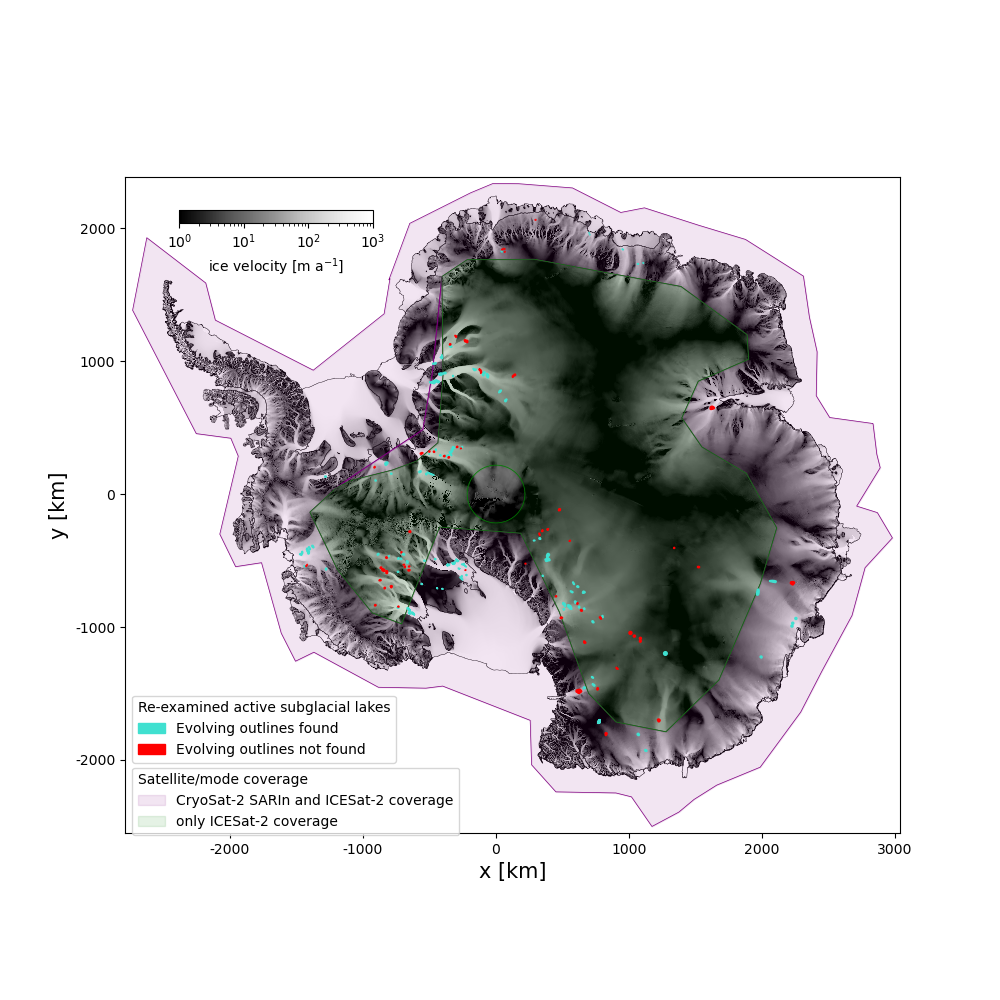

In [17]:
# Get the bounds of the CryoSat-2 SARIn mode mask GeoDataFrame
bounds = gdf_SARIn_3_1.geometry.bounds

# Extract the min and max x and y values from the bounds
x_min, x_max = bounds['minx'].min(), bounds['maxx'].max()
y_min, y_max = bounds['miny'].min(), bounds['maxy'].max()
x_buffer, y_buffer = (x_max-x_min)*0.01, (y_max-y_min)*0.01, 

# Create fig and axes objects
fig, ax = plt.subplots(figsize=(10,10))

# Plot ice-surface velocity
# cax = vel_mag.plot(ax=ax, cmap='Greys_r', norm=LogNorm(vmin=vel_mag.min(), vmax=vel_mag.max()), zorder=2)
cax = vel_mag.plot(ax=ax, cmap='Greys_r', norm=LogNorm(vmin=1, vmax=1000), zorder=1, add_colorbar=False)

# Plot Scripps grounding line
# Use black facecolor to fill in gaps in velocity array
Scripps_landice.boundary.plot(ax=ax, linewidth=0.25, edgecolor='k', facecolor='k', zorder=0) 
Scripps_landice.boundary.plot(ax=ax, linewidth=0.25, edgecolor='k', facecolor=None, zorder=2) 
Scripps_iceshelf.boundary.plot(ax=ax, linewidth=0.25, edgecolor='k', facecolor=None, zorder=2) 
Scripps_icerise.boundary.plot(ax=ax, linewidth=0.25, edgecolor='k', facecolor=None, zorder=2) 

# # Plot MOA coast and grounding lines  
# moa_2014_coastline.plot(ax=ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
# moa_2014_groundingline.plot(ax=ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)

# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=ax, edgecolor='purple', facecolor='purple', alpha=0.1, zorder=3)
gdf_SARIn_3_1.boundary.plot(ax=ax, color='purple', linewidth=0.5, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='purple', facecolor='purple', alpha=0.1, zorder=3)
gdf_SARIn_3_1_3_6_diff.boundary.plot(ax=ax, color='purple', linewidth=0.5, zorder=3)
CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)

# Create ICESat-2 pole hole geodataframe
center_x, center_y = 0, 0  # Geographic South Pole
x, y = ll2ps(0, -88)
radius = y  # Radius from Geographic South Pole to -88 S latitude (ICESat-2's southernmost coverage)
del x, y
IS2_pole_hole_poly = Point(center_x, center_y).buffer(radius)
IS2_pole_hole_gdf = gpd.GeoDataFrame(index=[0], geometry=[IS2_pole_hole_poly], crs="EPSG:3031")
IS2_pole_hole_gdf = IS2_pole_hole_gdf.to_crs(epsg=4326)

# IS2 interior to CS2 SARIn mode coverage
IS2_interior_poly = Polygon(shell=CS2_SARIn_union_gdf.geometry[0].interiors[0].coords, 
                            holes=[IS2_pole_hole_gdf.geometry[0].exterior.coords])
IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
IS2_interior_gdf.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.1, zorder=3)
IS2_interior_gdf.boundary.plot(ax=ax, color='green', linewidth=0.5, zorder=3)

# Overlay previously identified active subglacial lake stationary outlines
stationary_lakes_color = 'turquoise'
# stationary_lakes_gdf.boundary.plot(ax=ax, facecolor=stationary_lakes_color, 
#     edgecolor=stationary_lakes_color, linewidth=1, alpha=1, zorder=4)
evolving_outlines_lakes.boundary.plot(ax=ax, facecolor=stationary_lakes_color, 
    edgecolor=stationary_lakes_color, linewidth=1, alpha=1, zorder=4)
quiescent_lakes.boundary.plot(ax=ax, facecolor='red', 
    edgecolor='red', linewidth=1, alpha=1, zorder=4)

# # Plot inset map to show where lakes with evolving outlines are found
# axIns = ax.inset_axes([0, 0, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
# axIns.annotate('A', xy=(0.02, 0.98), xycoords='axes fraction', 
#                fontsize=12, fontweight='bold', va='top')
# axIns.set_aspect('equal')
# moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
# moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
# evolving_outlines_lakes.boundary.plot(ax=axIns, facecolor=stationary_lakes_color, 
#     edgecolor=stationary_lakes_color, linewidth=1, alpha=1, zorder=4)
# quiescent_lakes.boundary.plot(ax=axIns, facecolor=stationary_lakes_color, 
#     edgecolor='red', linewidth=1, alpha=1, zorder=4)
# axIns.axis('off')

# # Create lines and patches for legend
# # Create an ellipse
# stationary_lakes_ellipse = mpatches.Ellipse((0.5, 0.5), 0.3, 0.1, edgecolor=stationary_lakes_color, facecolor=stationary_lakes_color, alpha=1)
# CS2_SARIn_patch = mpatches.Patch(edgecolor='purple', facecolor='purple', alpha=0.05)
# IS2_patch = mpatches.Patch(edgecolor='green', facecolor='green', alpha=0.05)

# # Create legend
# ax.legend([stationary_lakes_ellipse, 
#            # packed_box, 
#            CS2_SARIn_patch, IS2_patch],
#     ['Previously identified active subglacial lakes', 
#      'CryoSat-2 SARIn and ICESat-2 coterminous coverage', 
#      'ICESat-2 coverage (CryoSat-2 SARIn unavailable)'], 
#     loc='upper left',
#     bbox_to_anchor=(0, 0.1),)

# Create patches for the two lake types
evolving_lakes_patch = mpatches.Patch(
    facecolor=stationary_lakes_color,
    edgecolor=stationary_lakes_color,
    label='Evolving outlines found'
)
quiescent_lakes_patch = mpatches.Patch(
    facecolor='red',
    edgecolor='red',
    label='Evolving outlines not found'
)

# Create patches for the other elements
cs2_patch = mpatches.Patch(
    facecolor='purple',
    edgecolor='purple',
    alpha=0.1,
    label='CryoSat-2 SARIn and ICESat-2 coterminous coverage'
)
is2_patch = mpatches.Patch(
    facecolor='green',
    edgecolor='green',
    alpha=0.1,
    label='ICESat-2 coverage (CryoSat-2 SARIn unavailable)'
)

# Create the legend with grouping
legend1 = ax.legend(
    [evolving_lakes_patch, quiescent_lakes_patch],
    ['Evolving outlines found', 'Evolving outlines not found'],
    title='Re-examined active subglacial lakes',
    loc='upper left',
    bbox_to_anchor=(0, 0.22),
    alignment='left'
)

# Add the second legend for the coverage areas
ax.add_artist(legend1)  # This keeps the first legend visible
ax.legend(
    [cs2_patch, is2_patch],
    ['CryoSat-2 SARIn and ICESat-2 coverage', 
     'only ICESat-2 coverage'],
    title='Satellite/mode coverage',
    loc='upper left',
    bbox_to_anchor=(0, 0.11),
    alignment='left'
)

# Change polar stereographic m to km
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)  

# Label axes
ax.set_xlabel('x [km]', size=15)
ax.set_ylabel('y [km]', size=15)

# Set axes limits
ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

# Plot colorbar
axins = inset_axes(ax, width="50%", height="2%", loc='upper left',
                   bbox_to_anchor=(0.07, -0.05, 0.5, 1),  # [left, bottom, width, height]
                   bbox_transform=ax.transAxes,
                   borderpad=0)
fig.colorbar(cax, cax=axins, label='ice velocity [m a$^{-1}$]', orientation='horizontal')

# Save and close plot
plt.savefig(OUTPUT_DIR + 'Fig1_subglacial_lake_distribution.png', dpi=300, bbox_inches='tight')

# Preview plot
plt.show()

In [ ]:
plt.close('all')